In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import pandas as pd
from scipy.signal import argrelextrema
from matplotlib.colors import LogNorm
from matplotlib import colors
import seaborn as sns 
import math
from scipy import signal
from PIL import Image
import numpy as np

matplotlib.rcParams.update({'font.size': 18})

In [7]:
# constants
c_0 = 3e8 # speed of light

In [99]:
# constants
c_0 = 3e8 # speed of light
microsteps = 800 # steps/rev
pitch = 5 # mm/rev
stepspermm = microsteps/pitch


# FMCW parameters
size_SAR_x = 400 # mm
size_SAR_y = 400 # mm

dy_sampling = 1 # mm
dx_motion_step = 1 # mm
num_x = size_SAR_x/dx_motion_step #
num_y = size_SAR_y/dy_sampling #
n_frms = int(1.30 * num_x * num_y)

v_testbed = 20.0 # mm/s
dt = dy_sampling/v_testbed # second

dCfg        =   {
                    "fStrt"     :   76e9,
                    "fStop"     :   78e9,
                    "TRampUp"   :   64e-6,
                    "TRampDo"   :   32e-6,
                    "TInt"      :   dt,
                    "N"         :   256,
                    "NrFrms"    :   n_frms,
                    "IniTim"    :   1000e-3,
                    "IniEve"    :   0
                }
n_ch = 1

file_exp = "42"
# output folder
#folder_output = '/home/qiwen/Github/UA_SAR/code/Analysis/RDA_2D_test_Feb/exp%s/'%file_exp
#folder_output = '/home/qiwen/Github/UA_SAR/code/Analysis/RDA_investigations/t_%ds/exp%s/'%(t_sar_actual,file_exp)
#folder_output = '/home/wq3939390/SAR_project/code/Analysis/Motion_Emulation/1Ddata/exp%s/'%file_exp
#folder_output = '/home/qiwen/Github/SAR_project/code/Analysis/motion_error_Sep2022/exp%s/'%file_exp
folder_output = '/home/wq3939390/SAR_project/code/Analysis/motion_error_Sep2022/exp%s/'%file_exp

In [100]:
path = '/home/wq3939390/SAR_project/code/Radarbook/Python/PyAppNotes/output/20221019/'
#path = '/home/qiwen/Github/SAR_project/data/20220302/'
data_time = np.loadtxt(path + "SAR_time_exp%s.csv"%file_exp, delimiter = ',')
data_R = np.loadtxt(path + "R_exp%s.txt"%file_exp, delimiter = ',')

# load radar data
data_radar = np.loadtxt(path + "SAR_data_exp%s.csv"%file_exp, delimiter = ',', dtype=complex)
# reshape radar data to match slowtime-fasttime-channel
data_radar = data_radar.reshape(n_frms,data_R.shape[0],n_ch)

In [101]:
# data to work on
df_grid_old = pd.read_pickle(folder_output+"2D_grid_mapped.pkl")
num = df_grid_old.shape[0]
df_grid_old

,Time,y [mm],x [mm],idx_radar,time_radar,time_error [ms],abs(time_error) [ms],position_error [mm]
764,1.666215e+09,1.0,0,463,1.666215e+09,1.129866,1.129866,0.019256
765,1.666215e+09,2.0,0,464,1.666215e+09,-6.047487,6.047487,0.103064
766,1.666215e+09,3.0,0,465,1.666215e+09,-16.527176,16.527176,0.281664
767,1.666215e+09,4.0,0,466,1.666215e+09,-23.520470,23.520470,0.400848
768,1.666215e+09,5.0,0,468,1.666215e+09,20.215273,20.215273,0.344519
...,...,...,...,...,...,...,...,...
166812,1.666226e+09,401.0,408,207514,1.666226e+09,16.750574,16.750574,0.285472
166813,1.666226e+09,402.0,408,207515,1.666226e+09,9.226322,9.226322,0.157240
166814,1.666226e+09,403.0,408,207516,1.666226e+09,2.274513,2.274513,0.038763
166815,1.666226e+09,404.0,408,207517,1.666226e+09,-8.343697,8.343697,0.142197


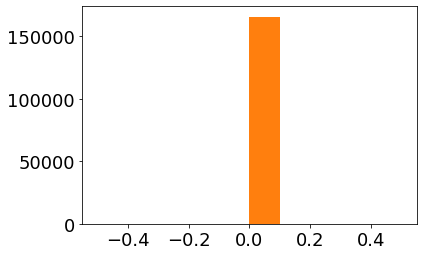

In [183]:
# set deviations
mu_dist = 0 # unit: mm
var_x = mu_dist**2/2
var_y = mu_dist**2/2

mean = [0,0]
cov = [[var_x,0],[0,var_y]]

#create a directory
directory = "MotionError_mu_"+str(mu_dist)+"/"
folder_path = os.path.join(folder_output, directory)   
try:
    os.mkdir(folder_path)
    print("Directory '% s' created" % directory)
except FileExistsError:
    # directory already exists
    pass


delta = np.random.multivariate_normal(mean, cov, num)
plt.hist(delta[:,0])
plt.hist(delta[:,1])

# add deviations to original positions
x0 = np.array(df_grid_old['x [mm]'])
y0 = np.array(df_grid_old['y [mm]'])
x_new = x0 + delta[:,0]
y_new = y0 + delta[:,1]

# boundary conditions
x_new[x_new<min(x0)]=min(x0)
x_new[x_new>max(x0)]=max(x0)
y_new[y_new<min(y0)]=min(y0)
y_new[y_new>max(y0)]=max(y0)

# round to grid
x_new = np.round(x_new)
y_new = np.round(y_new)

In [184]:
folder_path

'/home/wq3939390/SAR_project/code/Analysis/motion_error_Sep2022/exp42/MotionError_mu_0/'

In [185]:
# initialize new dataframe
df_grid = pd.DataFrame()
df_grid['Time'] = df_grid_old['Time']
df_grid['y [mm]'] = df_grid_old['y [mm]']
df_grid['x [mm]'] = df_grid_old['x [mm]']
df_grid['picked data from y [mm]'] = y_new
df_grid['picked data from x [mm]'] = x_new
rms_pos = np.sqrt(np.square(x_new-x0) + np.square(y_new-y0))
df_grid['position_error [mm]'] = rms_pos
df_grid

,Time,y [mm],x [mm],picked data from y [mm],picked data from x [mm],position_error [mm]
764,1.666215e+09,1.0,0,1.0,0.0,0.0
765,1.666215e+09,2.0,0,2.0,0.0,0.0
766,1.666215e+09,3.0,0,3.0,0.0,0.0
767,1.666215e+09,4.0,0,4.0,0.0,0.0
768,1.666215e+09,5.0,0,5.0,0.0,0.0
...,...,...,...,...,...,...
166812,1.666226e+09,401.0,408,401.0,408.0,0.0
166813,1.666226e+09,402.0,408,402.0,408.0,0.0
166814,1.666226e+09,403.0,408,403.0,408.0,0.0
166815,1.666226e+09,404.0,408,404.0,408.0,0.0


In [186]:
# now find radar index based on new positions
idx_radar_old = np.array(df_grid_old['idx_radar'])
idx_radar_new = []

for k in range(x_new.shape[0]):
    idx = np.where((y0==y_new[k])&(x0==x_new[k]))
    idx_radar = idx_radar_old[idx][0]
    idx_radar_new.append(idx_radar.real)

df_grid['idx_radar'] = idx_radar_new
df_grid['time_radar'] = data_time[idx_radar_new]
df_grid

,Time,y [mm],x [mm],picked data from y [mm],picked data from x [mm],position_error [mm],idx_radar,time_radar
764,1.666215e+09,1.0,0,1.0,0.0,0.0,463,1.666215e+09
765,1.666215e+09,2.0,0,2.0,0.0,0.0,464,1.666215e+09
766,1.666215e+09,3.0,0,3.0,0.0,0.0,465,1.666215e+09
767,1.666215e+09,4.0,0,4.0,0.0,0.0,466,1.666215e+09
768,1.666215e+09,5.0,0,5.0,0.0,0.0,468,1.666215e+09
...,...,...,...,...,...,...,...,...
166812,1.666226e+09,401.0,408,401.0,408.0,0.0,207514,1.666226e+09
166813,1.666226e+09,402.0,408,402.0,408.0,0.0,207515,1.666226e+09
166814,1.666226e+09,403.0,408,403.0,408.0,0.0,207516,1.666226e+09
166815,1.666226e+09,404.0,408,404.0,408.0,0.0,207517,1.666226e+09


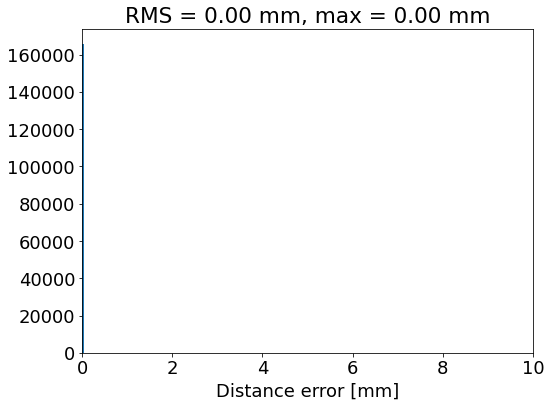

In [187]:
# error in time and position

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.hist(df_grid['position_error [mm]'],bins=20)

rms = np.sqrt(np.mean(np.square(df_grid['position_error [mm]'])))

ax.set_title('RMS = %.2f mm, max = %.2f mm'%(rms,np.max(df_grid['position_error [mm]'])))
ax.set_xlabel('Distance error [mm]')
ax.set_xlim(0,10)
plt.tight_layout()
fig.savefig(folder_output+"MotionError_mu_%d/grid_mapping_error.jpg"%mu_dist)
plt.show()

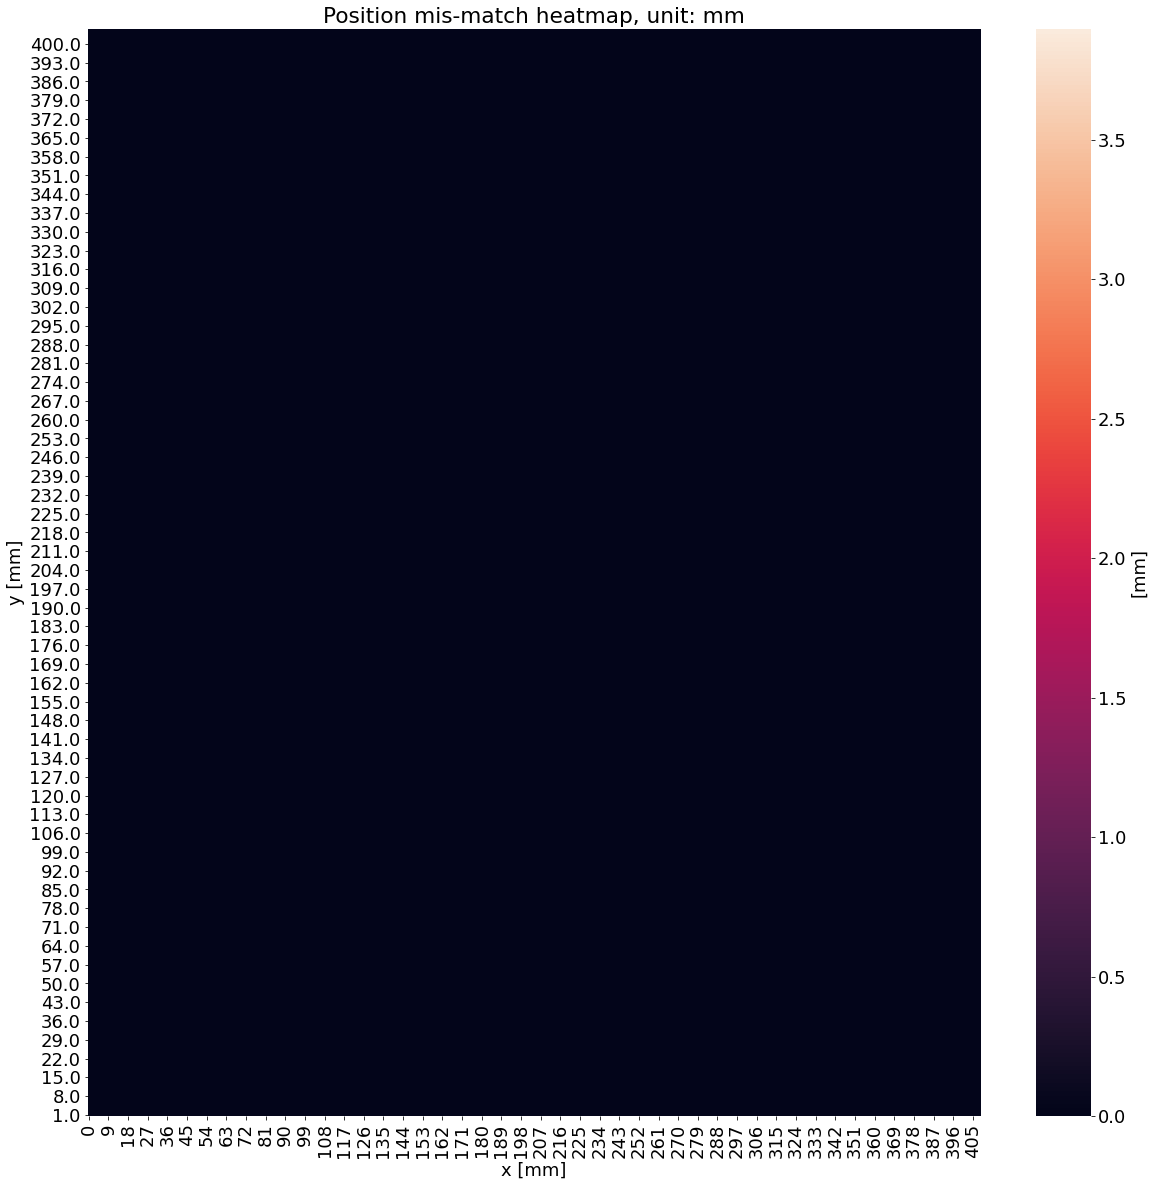

In [188]:
wavelength = c_0/(0.5*(dCfg["fStrt"] + dCfg["fStop"]))
fig = plt.figure(figsize=(20,20))
table = df_grid.pivot('y [mm]', 'x [mm]', 'position_error [mm]')
ax = sns.heatmap(table,cbar_kws={'label': '[mm]'}, vmin=0, vmax=1*wavelength*1e3)
ax.invert_yaxis()
plt.title("Position mis-match heatmap, unit: mm")
fig.savefig(folder_output+"MotionError_mu_%d/grid_mapping_PositionError_heatmap.jpg"%mu_dist)

plt.show()

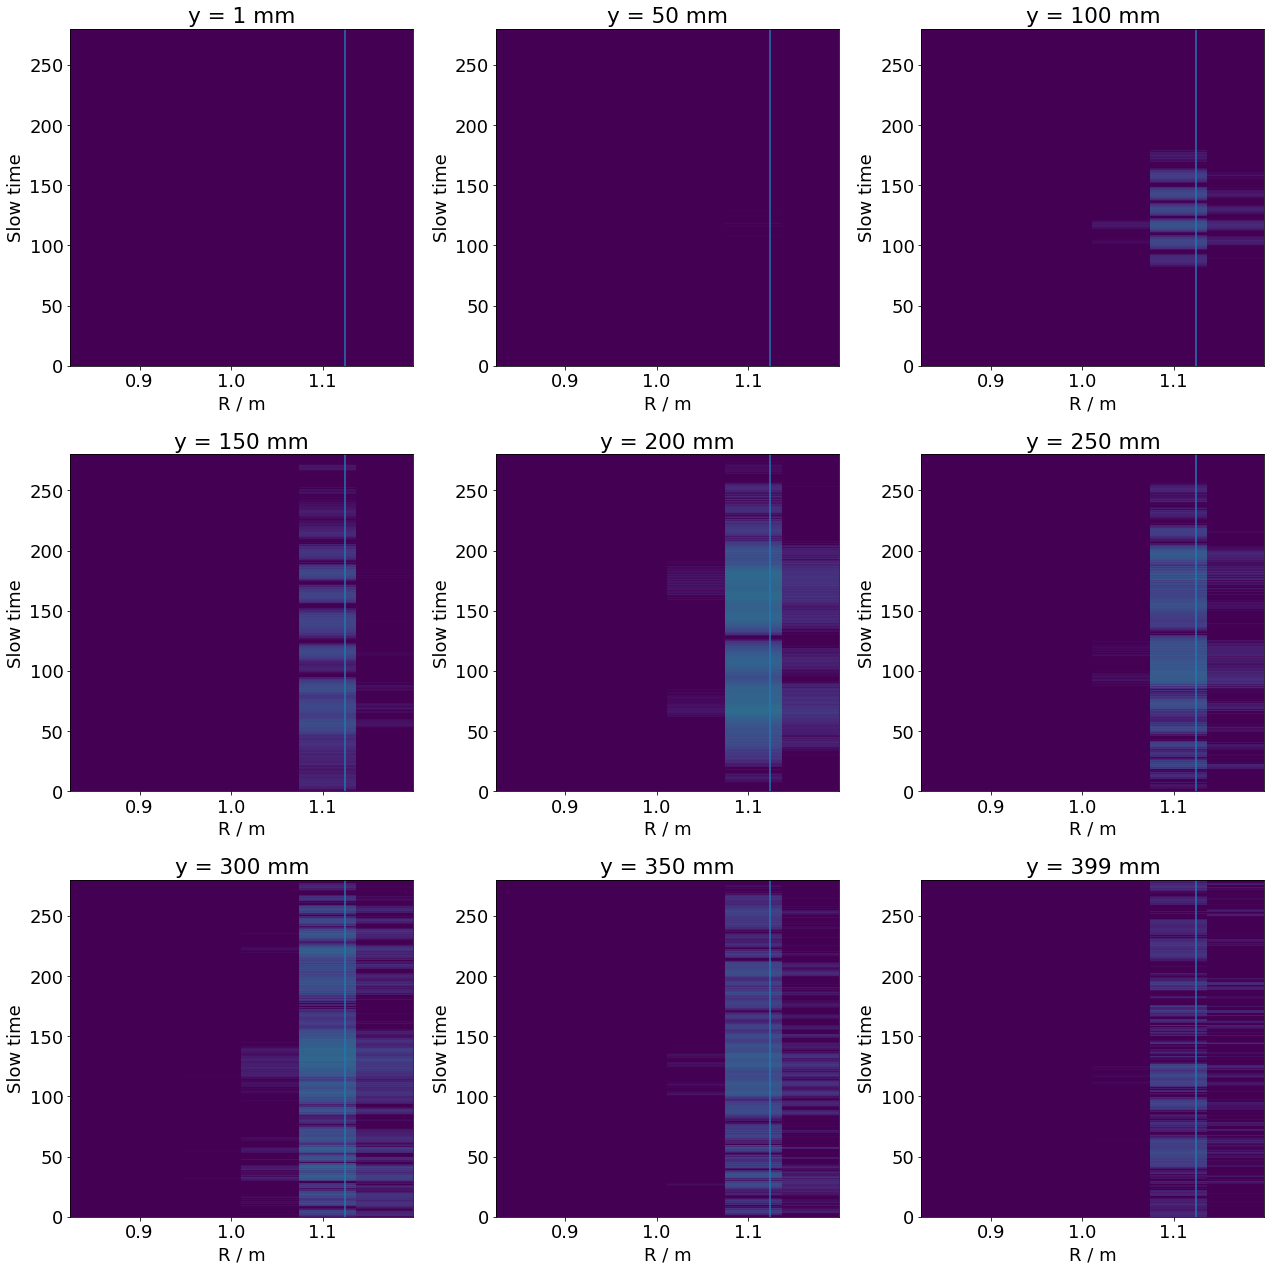

In [189]:
ch=0
idx_R = 4

fig, ax = plt.subplots(3,3, figsize=(18,18))
#fig.suptitle('Ch:%d'%ch)
for k,y in enumerate([1,50, 100, 150, 200, 250, 300, 350,399]):
    df_y = df_grid[df_grid['y [mm]']==y]
    df_y['idx_radar'].tolist()
    data_radar_y = data_radar[df_y['idx_radar'].tolist()]
    
    ax[int(k/3),k%3].set_title('y = %d mm'%(y))
    

    
    z1_plot = ax[int(k/3),k%3].imshow((np.abs(data_radar_y[:,:,ch])),extent = [np.min(data_R),np.max(data_R),0,280],norm=LogNorm(vmin=1e3, vmax=1e6),interpolation='none', aspect='auto', origin = 'lower')
    #z1_plot = ax[int(k/3),k%3].imshow((np.abs(data_radar_y[:,:,ch])),extent = [np.min(data_R),np.max(data_R),0,280],interpolation='none', aspect='auto', origin = 'lower')
    ax[int(k/3),k%3].axvline(data_R[idx_R ])
    ax[int(k/3),k%3].set_xlabel('R / m')
    ax[int(k/3),k%3].set_ylabel('Slow time')
    #plt.colorbar(z1_plot,ax=ax[int(k/3),k%3])
plt.tight_layout()

In [190]:
# store the radar data into dataframe

for idx_maxP in range(0,len(data_R)):
    a = data_radar[df_grid['idx_radar'].tolist()]
    df_grid['radar_ch1'] = a[:,idx_maxP,0]
    #df_grid['radar_ch2'] = a[:,idx_maxP,1]
    df_grid.to_pickle(folder_output+"MotionError_mu_%d/2D_grid_mapped_R0_idx%d.pkl"%(mu_dist,idx_maxP))
    df_grid